In [71]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from vae_methods import *
from fpfn import function
import seaborn as sns
from IPython import display

# Reading in the data. 
## For training, we combined several files which had no attacks and for testing we used a single file where there were attacks and no attacks.
## The training data has 157579 datapoints and testing data has 1924 datapoints, out of which 956 are instances without attacks and 968 are instances with attacks

In [2]:
train = pd.read_csv('Level Control CSVs/Combined.csv')
train.drop(["millis"], axis = 1, inplace = True)

In [3]:
test = pd.read_csv('2022-1-26--14-18-55_CycleValues.csv')
test.drop(['millis'], axis = 1, inplace = True)

In [4]:
train.head()

,Start,Stop,Reset,'FACTORY I/O (Running)','FACTORY I/O (Paused)','FACTORY I/O (Reset)','Level meter','Flow meter',Setpoint,'FACTORY I/O (Time Scale)',...,'Stop light','Reset light','FACTORY I/O (Run)','FACTORY I/O (Pause)','FACTORY I/O (Reset1)','Fill valve','Discharge valve',SP,PV,'FACTORY I/O (Camera Position)'
0,0,1,0,1,0,0,0.0,0.0,0.0,0.2,...,0,0,1,0,0,0.0,0.0,0,0,0
1,0,1,0,1,0,0,0.0,0.0,0.0,0.2,...,0,0,1,0,0,0.0,0.0,0,0,0
2,0,1,0,1,0,0,0.0,0.0,0.0,0.2,...,0,0,1,0,0,0.0,0.0,0,0,0
3,0,1,0,1,0,0,0.0,0.0,0.0,0.2,...,0,0,1,0,0,0.0,0.0,0,0,0
4,0,1,0,1,0,0,0.0,0.0,0.0,0.2,...,0,0,1,0,0,0.0,0.0,0,0,0


In [5]:
test.head()

,Start,Stop,Reset,'FACTORY I/O (Running)','FACTORY I/O (Paused)','FACTORY I/O (Reset)','Level meter','Flow meter',Setpoint,'FACTORY I/O (Time Scale)',...,'Reset light','FACTORY I/O (Run)','FACTORY I/O (Pause)','FACTORY I/O (Reset1)','Fill valve','Discharge valve',SP,PV,'FACTORY I/O (Camera Position)',attack
0,0,1,0,1,0,0,0.0,0.0,0.0,1,...,0,1,0,0,0.0,0.0,0,0,0,0
1,0,1,0,1,0,0,0.0,0.0,0.0,1,...,0,1,0,0,0.0,0.0,0,0,0,0
2,0,1,0,1,0,0,0.0,0.0,0.0,1,...,0,1,0,0,0.0,0.0,0,0,0,0
3,0,1,0,1,0,0,0.0,0.0,0.0,1,...,0,1,0,0,0.0,0.0,0,0,0,0
4,0,1,0,1,0,0,0.0,0.0,0.0,1,...,0,1,0,0,0.0,0.0,0,0,0,0


## Our training dataframe doesn't have the label column. However, since we know that all datapoints are instances without attacks we set the label of all the datapoints as 0

In [6]:
train['attack'] = train.shape[0] * [0]

## Several columns in our data are static, i.e. the values in the column remain the same throughout the entire data. We will drop these static columns to reduce dimensionality.  
## We also try to find categorical columns, so we can apply one-hot encoding to them. All other columns are numerical, so we apply scaling to them.

In [7]:
train.shape

(157579, 22)

In [8]:
test.shape

(1924, 22)

In [9]:
for cols in train.columns:
    print(cols)
    print("Min:",train[cols].min())
    print("Max:",train[cols].max())
    print()

Start
Min: 0
Max: 0

Stop
Min: 1
Max: 1

Reset
Min: 0
Max: 0

'FACTORY I/O (Running)'
Min: 1
Max: 1

'FACTORY I/O (Paused)'
Min: 0
Max: 0

'FACTORY I/O (Reset)'
Min: 0
Max: 0

'Level meter'
Min: 0.0
Max: 6.605333

'Flow meter'
Min: 0.0
Max: 3.146235

Setpoint
Min: 0.0
Max: 5.965183

'FACTORY I/O (Time Scale)'
Min: 0.2
Max: 1.0

'Start light'
Min: 0
Max: 0

'Stop light'
Min: 0
Max: 0

'Reset light'
Min: 0
Max: 0

'FACTORY I/O (Run)'
Min: 1
Max: 1

'FACTORY I/O (Pause)'
Min: 0
Max: 0

'FACTORY I/O (Reset1)'
Min: 0
Max: 0

'Fill valve'
Min: 0.0
Max: 10.0

'Discharge valve'
Min: 0.0
Max: 4.0

SP
Min: 0
Max: 178

PV
Min: 0
Max: 198

'FACTORY I/O (Camera Position)'
Min: 0
Max: 0

attack
Min: 0
Max: 0



## We find static columns by finding the columns whose maximum value is equal to the minimum value. There are 13 such static columns other than our label column.
## Categorical columns are found by checking number of unique values in a column. If the number of unique values is between 2 and a threshold (we set it as 5) we consider that column as categorical, if the number of unique values are greater than 5, then we consider it as a numerical column. We found no categorical columns in this dataset.

In [10]:
static_columns = []

for column in train.columns:
    if train[column].max() == train[column].min():
        static_columns.append(column)
        
def check_categorical(dataframe, threshold):
    
    categorical_columns = {}

    for cols in dataframe.columns:
        
        if dataframe[cols].nunique() in range(2,threshold):
            
            categorical_columns[cols] = dataframe[cols].nunique()

    return categorical_columns


In [11]:
print(static_columns)

['Start', 'Stop', 'Reset', "'FACTORY I/O (Running)'", "'FACTORY I/O (Paused)'", "'FACTORY I/O (Reset)'", "'Start light'", "'Stop light'", "'Reset light'", "'FACTORY I/O (Run)'", "'FACTORY I/O (Pause)'", "'FACTORY I/O (Reset1)'", "'FACTORY I/O (Camera Position)'", 'attack']


In [12]:
len(static_columns)

14

In [13]:
categorical_columns = check_categorical(train,5)

In [14]:
categorical_columns

{}

In [15]:
label_column = ['attack']

In [16]:
numerical_columns = list(set(train.columns) - set(static_columns + label_column))

In [17]:
numerical_columns

["'Flow meter'",
 'PV',
 "'Discharge valve'",
 "'Level meter'",
 'Setpoint',
 "'Fill valve'",
 "'FACTORY I/O (Time Scale)'",
 'SP']

## In the preprocessing step we drop the static columns and label column. We also apply scaling and return the scaler, so it can be used on the testing data.

In [18]:
def preprocess(dataframe, static_columns, label_column, numerical_columns, scaler = None):
    
    df = dataframe.drop(columns = static_columns + label_column)
    labels = dataframe[label_column]
    
    if scaler:
        df = scaler.transform(df)
        return df,labels
    else:
        scaler = StandardScaler()
        df = scaler.fit_transform(df)
        return df,labels,scaler
    

## We convert our data to sequences, since time-series models including transformers work on sequences.
## Suppose our data is [1, 2, 3, 4, 5] and the labels are [0, 0, 1, 1, 1], if we choose a sequence size of 2, our training data will be converted into this form:
## X = [[1, 2], [2, 3], [3, 4]], y = [1, 1, 1] where x is the data and y are the labels

In [19]:
def to_sequences(x, y, seq_size = 1):
    x_vals = []
    y_vals = []
    
    for i in range(len(x) - seq_size):
        x_vals.append(x[i : (i+seq_size)])
        y_vals.append(y.values[i+seq_size])              
        
    return np.array(x_vals), np.array(y_vals)

In [20]:
x_train, y_train, scaler = preprocess(train, static_columns, label_column, numerical_columns)
x_test, y_test = preprocess(test, static_columns, label_column, numerical_columns, scaler)

## After comparing several sequence sizes, we found sequence size of 2 to produce the best results on this data

In [21]:
seq_size = 2
x_train_seq, y_train_seq = to_sequences(x_train, y_train, seq_size)
x_test_seq, y_test_seq = to_sequences(x_test, y_test, seq_size) 

In [22]:
print(x_train_seq.shape)
print(y_train_seq.shape)

(157577, 2, 8)
(157577, 1)


In [23]:
print(x_test_seq.shape)
print(y_test_seq.shape)

(1922, 2, 8)
(1922, 1)


## Multi head attention is arguably one of the most important parts of the transformer block. It allows attention mechanism to run several times in parallel, which are then concatenated

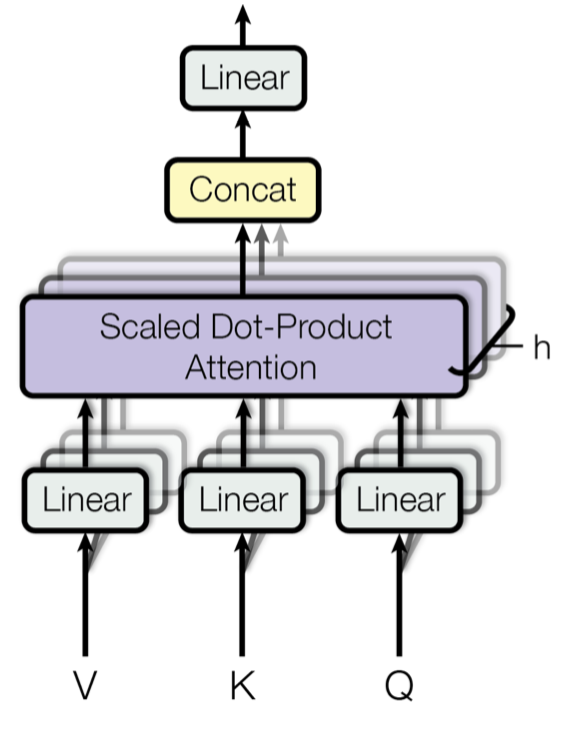

In [64]:
display.Image("multi-head-attention_l1A3G7a..png")

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [25]:
input_shape = x_train_seq.shape[1:]
features = x_train_seq.shape[-1]

## To implement attention in our VAE, we first put in some transformer blocks, after which we apply pooling. Applying pooling helps us to feed the output of the transformer blocks to the fully connected layers. After pooling we have 2 dense layers. This makes up our encoder half. The output of the encoder is mapped into a latent space (bottleneck layer). The output of the latent space is then passed through a repeat vector layer, which just copies the input and concatenates it to itself to increase dimensionality. This is then passed again to transformer blocks. The output of the transformer blocks is passed through 2 Fully connected layers, then we finally arrive at the output layer

In [26]:
def attention_vae(latent_dim,
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks):
    
    inputs = keras.Input(shape = input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
        
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    dense1_vae = layers.Dense(features - 3, activation='relu')(x)

    dense2_vae = layers.Dense(features - 5, activation='relu')(dense1_vae)

    z_mean = layers.Dense(latent_dim, name="z_mean")(dense2_vae)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(dense2_vae)
    z = Sampling()([z_mean, z_log_var])

    encoder_vae = keras.Model(inputs=inputs,
                            outputs=[z_mean, z_log_var, z],
                            name='LSTM_VAE_encoder')

    inputs_decoder_vae = keras.Input(shape=(latent_dim,))

    repeat_vec = layers.RepeatVector(seq_size)(inputs_decoder_vae)

    for i in range(num_transformer_blocks):
        if i == 0:
            x = transformer_encoder(repeat_vec, head_size, num_heads, ff_dim)
        else:
            x = transformer_encoder(x, head_size, num_heads, ff_dim)
            

    dense1_decoder_vae = layers.Dense(features - 3, activation='relu')(x)

    dense2_decoder_vae = layers.Dense(features - 1, activation='relu')(dense1_decoder_vae)

    decoder_outputs_vae = layers.Dense(features, name='decoder_outputs')(dense2_decoder_vae)

    decoder_vae = keras.Model(inputs=inputs_decoder_vae,
                            outputs=decoder_outputs_vae,
                            name='attention_VAE_decoder')

    attention_vae = VAE(encoder_vae, decoder_vae)

    def vae_loss(data, reconstruction): #y_true, y_pred
        mu, ln_var, z = attention_vae.encoder(data)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = 1 + ln_var - tf.square(mu) - tf.exp(ln_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        return total_loss

    attention_vae.compile(loss=vae_loss, optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1))

    return attention_vae
    
    

## We define two callbacks. Early stopping and reduced learning rate. Reduced learning rate allows us to reduce the learning rate if the validation loss isn't changing for 5 epochs early stopping stops the training of the model if the validation loss doesn't improve for 10 epochs. The best weights are saved.

In [27]:
early_stopping_callback_hyperopt = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)


reduce_lr_calllback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.15,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

In [28]:
attention_vae = attention_vae(latent_dim = features - 4,
                 input_shape = input_shape, 
                 head_size = 256,
                 num_heads = 8,
                 ff_dim = 4,
                 num_transformer_blocks = 8)

2022-11-11 16:03:48.547764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 16:03:48.557816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 16:03:48.558559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 16:03:48.559846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
hist = attention_vae.fit(x_train_seq, x_train_seq,
                  epochs = 2000,
                  batch_size = 128,
                  validation_split = 0.15,
                  callbacks = [early_stopping_callback_hyperopt, reduce_lr_calllback])

Epoch 1/2000


2022-11-11 16:04:15.745427: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-11-11 16:04:16.412932: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-11 16:04:16.413711: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-11 16:04:16.413789: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-11 16:04:16.414563: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-11 16:04:16.414691: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1047/1047 [==============================] - 107s 79ms/step - total_loss: 1.0503 - reconstruction_loss: 1.0393 - kl_loss: 0.0110 - val_loss: 0.8998 - lr: 0.0010
Epoch 2/2000
1047/1047 [==============================] - 80s 76ms/step - total_loss: 1.0349 - reconstruction_loss: 1.0347 - kl_loss: 2.2396e-04 - val_loss: 0.8979 - lr: 0.0010
Epoch 3/2000
1047/1047 [==============================] - 79s 76ms/step - total_loss: 1.0351 - reconstruction_loss: 1.0351 - kl_loss: 4.5099e-05 - val_loss: 0.8952 - lr: 0.0010
Epoch 4/2000
1047/1047 [==============================] - 80s 77ms/step - total_loss: 1.0350 - reconstruction_loss: 1.0349 - kl_loss: 3.6181e-05 - val_loss: 0.8930 - lr: 0.0010
Epoch 5/2000
1047/1047 [==============================] - 80s 77ms/step - total_loss: 1.0343 - reconstruction_loss: 1.0343 - kl_loss: 5.9627e-06 - val_loss: 0.9006 - lr: 0.0010
Epoch 6/2000
1047/1047 [==============================] - 80s 77ms/step - total_loss: 1.0343 - reconstruction_loss: 1.0343 - kl_los

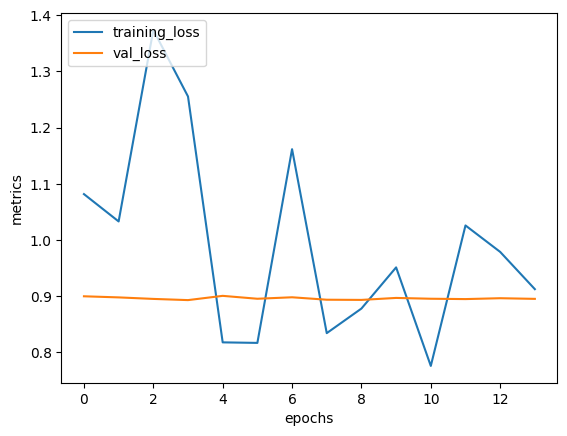

In [66]:
plt.plot(hist.history['total_loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.legend(['training_loss', 'val_loss'], loc='upper left')

## The output of the model is simply the attempted reconstuction of the input data. The threshold is defined as the 75% quatile of the training loss. This threshold will help us to compute predictions.

In [31]:
train_reconstructions = attention_vae.predict(x_train_seq)
train_loss = keras.losses.mean_squared_error(x_train_seq, train_reconstructions)
threshold = np.quantile(train_loss, 0.75)

4925/4925 [==============================] - 74s 15ms/step


## To get predictions, we compute the loss of the data with the reconstruction(output of the model). If the loss is greater than the threshold, then the model hasn't reconstructed the input very well. Since our training data is comprised of only non-attack data, the reconstructions should be less than the threshold, if the input is non-attack data.

## So, if the loss is greater than the threshold, the input data must correspond to attack data. Else, it must correspond to non-attack data.

In [32]:
def predict(data, reconstructions, threshold):
    loss = tf.keras.losses.mean_squared_error(data, reconstructions)
    return ~tf.math.less(loss, threshold)

In [33]:
train_predictions = predict(x_train_seq, train_reconstructions, threshold)

## Since the predictions are of the same dimensions as of the input, we must convert them into (n * 1) dimension. We do this using numpy strided techniques.

In [34]:
strided_train_predictions = np.lib.stride_tricks.as_strided(train_predictions, shape=(train_predictions.shape[0],1), strides=np.array(train_predictions).strides)

## Result analysis

In [35]:
def show_results(model, x, labels, data_name, threshold, sequence = False, window = 4):
    
    if not sequence:
        data_seq = sequencify(x, window)
        reconstructions = model.predict(data_seq)
        sequencified_labels = labels[window-1:].reshape(-1,1)
        predictions = predict(data_seq, reconstructions, threshold)
        strided_predictions = np.lib.stride_tricks.as_strided(predictions, shape=(predictions.shape[0],1), strides=np.array(predictions).strides)
    else:
        reconstructions = model.predict(x)
        sequencified_labels = labels
        predictions = predict(x, reconstructions, threshold)
        strided_predictions = np.lib.stride_tricks.as_strided(predictions, shape=(predictions.shape[0],1), strides=np.array(predictions).strides)

    print("----------------------------")
    print(f"{data_name}ing Result")
    print("----------------------------")
    print("Accuracy = {}".format(accuracy_score(sequencified_labels, strided_predictions)))
    print("Precision = {}".format(precision_score(sequencified_labels, strided_predictions, zero_division=0)))
    print("Recall = {}".format(recall_score(sequencified_labels, strided_predictions, zero_division=0)))
    print("F1 = {}".format(f1_score(sequencified_labels, strided_predictions, zero_division=0)))

    
    cf = confusion_matrix(sequencified_labels,strided_predictions)
    ax = sns.heatmap(cf, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
        

4925/4925 [==============================] - 72s 15ms/step
----------------------------
Training Result
----------------------------
Accuracy = 0.7498429339307132
Precision = 0.0
Recall = 0.0
F1 = 0.0


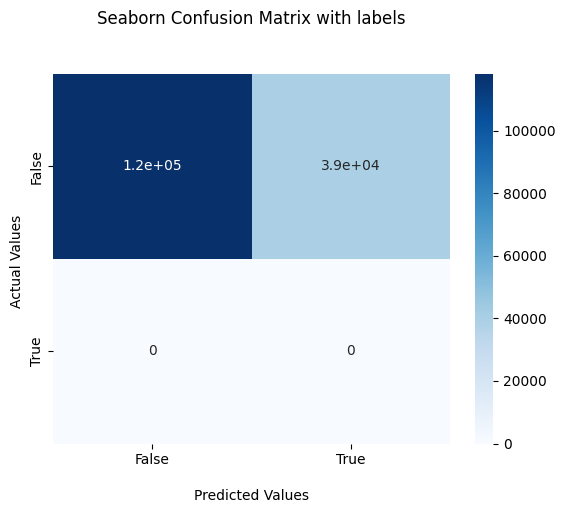

In [36]:
show_results(attention_vae, x_train_seq, y_train_seq, "Train", threshold, sequence = True, window = seq_size)

5 attacks were detected out of 0
Attacks detected during these times:[(10118, 26321), (29187, 29924), (128907, 132290), (137268, 152063), (153280, 157576)]
Attacks are actually during these times:[]


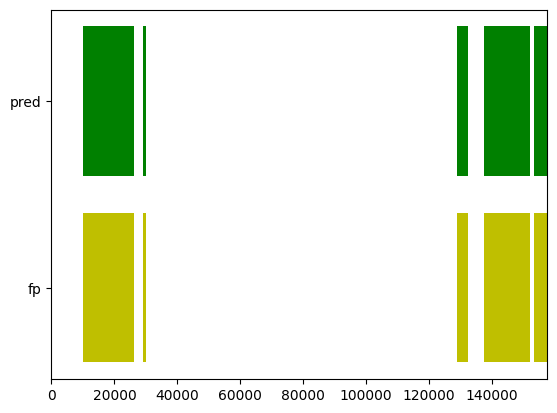

In [72]:
function(y_train_seq, strided_train_predictions)

## We dont have any False Positives, but we have some False Negatives, which means the model is unable to detect a few attacks.

61/61 [==============================] - 1s 16ms/step
----------------------------
Testing Result
----------------------------
Accuracy = 0.8465140478668054
Precision = 1.0
Recall = 0.6952479338842975
F1 = 0.8202315661182206


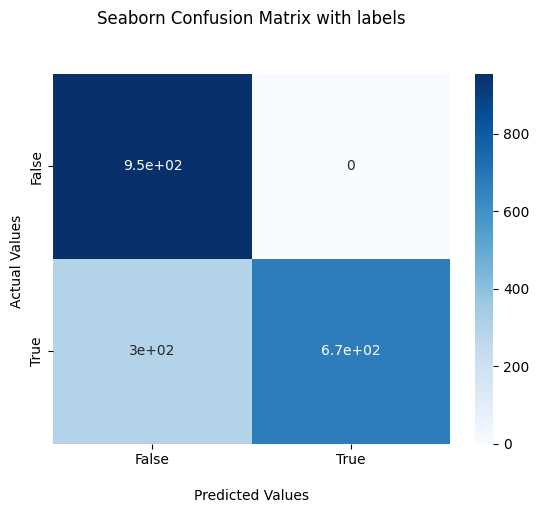

In [37]:
show_results(attention_vae, x_test_seq, y_test_seq, "Test", threshold, sequence = True, window = seq_size)

In [50]:
test_reconstructions = attention_vae.predict(x_test_seq)
test_predictions = predict(x_test_seq, test_reconstructions, threshold)
strided_test_predictions = np.lib.stride_tricks.as_strided(test_predictions, shape=(test_predictions.shape[0],1), strides=np.array(test_predictions).strides)

61/61 [==============================] - 1s 15ms/step


4 attacks were detected out of 1
Attacks detected during these times:[(1176, 1211), (1239, 1587), (1615, 1706), (1726, 1921)]
Attacks are actually during these times:[(954, 1921)]


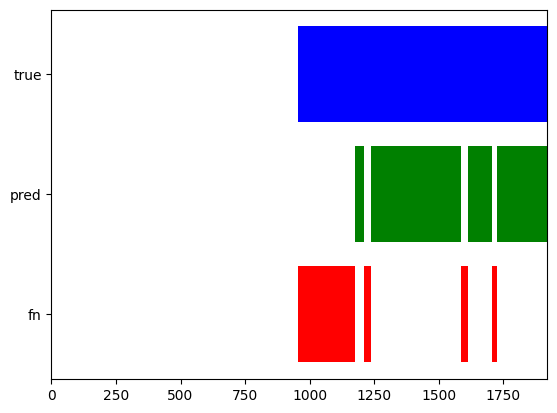

In [73]:
function(y_test_seq, strided_test_predictions)